<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-locations" data-toc-modified-id="Read-locations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read locations</a></span></li><li><span><a href="#Download-NASADEM" data-toc-modified-id="Download-NASADEM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Download NASADEM</a></span></li><li><span><a href="#Download-corine" data-toc-modified-id="Download-corine-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Download corine</a></span></li></ul></div>

In [1]:
import io
import pandas as pd
import geopandas as gpd
import numpy as np
import fiona as fio
import rasterio as rio
import shapely.geometry as sg
import zipfile
import requests

In [2]:
from pathlib import Path
OUT_PATH = Path('.').resolve()
OUT_PATH

PosixPath('/home/ewsuser/ews_drives/s_EWSProjects/GralDispersionModel/ValidationCases/Askervein/00_input_data')

# Read locations

In [3]:
locs_gdf = pd.read_csv(io.StringIO(r'''Name,X,Y,AGL,GridRefX,GridRefY
RS tower 1 m,-99,-1062,1,74300,820980
RS tower 3 m,-99,-1062,3,74300,820980
RS tower 5 m,-99,-1062,5,74300,820980
RS tower 8 m,-99,-1062,8,74300,820980
RS tower 15 m,-99,-1062,15,74300,820980
RS tower 24 m,-99,-1062,24,74300,820980
RS tower 34 m,-99,-1062,34,74300,820980
RS tower 49 m,-99,-1062,49,74300,820980
Cemetary BM,-1019,-102,-10000,73380,821940
Milestone,885,-328,-10000,75284,821714
TV tower,-809,-331,-10000,73590,821711
Base station,447,1264,-10000,74846,823306
Pacman lake,1808,1545,-10000,76207,823587
Askernish House,-745,1803,-10000,73654,823845
HT Hill Top,984,1695,10,75383,823737
HT 10 m mf,988,1693,10,75387,823735
HT 10 m t,982,1703,10,75381,823745
HT tower 1 m,982,1711,1,75381,823753
HT tower 3 m,982,1711,3,75381,823753
HT tower 5 m,982,1711,5,75381,823753
HT tower 8 m,982,1711,8,75381,823753
HT tower 15 m,982,1711,15,75381,823753
HT tower 24 m,982,1711,24,75381,823753
HT tower 34 m,982,1711,34,75381,823753
HT tower 49 m,982,1711,49,75381,823753
HT WM,961,1721,10,75360,823763
CP Centre Point,1279,1423,10,75678,823465
CP UK mf,1287,1415,10,75686,823457
CP BSE 40,1281,1422,10,75680,823464
CP FRG mf,1277,1424,10,75676,823466
CP FRG 17 m tower,1289,1451,16,75688,823493
BNW10,914,1768,10,75313,823810
BNW20,844,1833,10,75243,823875
BSE10,1059,1629,10,75458,823671
BSE20,1129,1561,10,75528,823603
BSE30,1207,1493,10,75606,823535
BSE40,1281,1423,10,75680,823465
BSE50,1355,1355,10,75754,823397
BSE60,1434,1282,10,75833,823324
BSE70,1506,1218,10,75905,823260
BSE80,1583,1151,10,75982,823193
BSE90,1647,1088,10,76046,823130
BSE100,1721,1021,10,76120,823063
BSE110,1796,955,10,76195,822997
BSE130,1939,818,10,76338,822860
BSE150,2091,681,10,76490,822723
BSE170,2237,543,10,76636,822585
ANE10,1055,1770,10,75454,823812
ANE20,1124,1842,10,75523,823884
ANE40,1262,1975,10,75661,824017
ASW10,920,1625,10,75319,823667
ASW20,858,1562,10,75257,823604
ASW35,763,1456,10,75162,823498
ASW50,651,1336,10,75050,823378
ASW UK 30 m tower,571,1253,30,74970,823295
ASW85,414,1080,10,74813,823122
AANE10,1347,1498,10,75746,823540
AANE20,1408,1568,10,75807,823610
AANE30,1472,1633,10,75871,823675
AANE40,1539,1703,10,75938,823745
AANE50,1607,1771,10,76006,823813
AANE60,1674,1844,10,76073,823886
AASW10 mf,1214,1354,10,75613,823396
AASW10 t,1224,1346,10,75623,823388
AASW20,1154,1278,10,75553,823320
AASW30 mf,1084,1211,10,75483,823253
AASW30 t,1094,1202,10,75493,823244
AASW40,1018,1132,10,75417,823174
AASW50 mf,942,1065,10,75341,823107
AASW50 t,953,1058,10,75352,823100
AASW60,875,996,10,75274,823038
AASW70,809,926,10,75208,822968
AASW80,741,853,10,75140,822895
AASW90,670,778,10,75069,822820'''), sep=',', index_col=0).astype('float')
locs_gdf = gpd.GeoDataFrame(locs_gdf).set_geometry(
    gpd.points_from_xy(locs_gdf.GridRefX, locs_gdf.GridRefY)
)
locs_gdf.crs = fio.crs.from_epsg(27700)

locs_gdf.reset_index().to_file(OUT_PATH / 'locations.geojson', driver='GeoJSON')
locs_gdf_wgs84 = locs_gdf.to_crs(epsg=4326).sort_values("AGL", ascending=False).reset_index().groupby(["GridRefX", "GridRefY"]).first().set_index('Name')
locs_gdf_wgs84 = gpd.GeoDataFrame(locs_gdf_wgs84, crs=fio.crs.from_epsg(4326))
locs_gdf_wgs84
gpd.read_file(OUT_PATH / 'locations.geojson', driver='GeoJSON').set_index('Name')

,X,Y,AGL,GridRefX,GridRefY,geometry
Name,,,,,,
RS tower 1 m,-99.0,-1062.0,1.0,74300.0,820980.0,POINT (74300 820980)
RS tower 3 m,-99.0,-1062.0,3.0,74300.0,820980.0,POINT (74300 820980)
RS tower 5 m,-99.0,-1062.0,5.0,74300.0,820980.0,POINT (74300 820980)
RS tower 8 m,-99.0,-1062.0,8.0,74300.0,820980.0,POINT (74300 820980)
RS tower 15 m,-99.0,-1062.0,15.0,74300.0,820980.0,POINT (74300 820980)
RS tower 24 m,-99.0,-1062.0,24.0,74300.0,820980.0,POINT (74300 820980)
RS tower 34 m,-99.0,-1062.0,34.0,74300.0,820980.0,POINT (74300 820980)
RS tower 49 m,-99.0,-1062.0,49.0,74300.0,820980.0,POINT (74300 820980)
Cemetary BM,-1019.0,-102.0,-10000.0,73380.0,821940.0,POINT (73380 821940)


In [4]:
import folium
location = sg.box(*locs_gdf_wgs84.total_bounds).centroid
Map = folium.Map(
    location = [location.y, location.x], 
    zoom_start = 13,
    tiles='http://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
    attr='OpenTopoMap'
)
locs = folium.map.FeatureGroup()
for name, row in locs_gdf_wgs84.iterrows():
    folium.Marker(
      location = [row.geometry.y, row.geometry.x],
      #name = name,
      popup = row.rename(name).drop("geometry").to_frame().to_html(),
      icon = folium.Icon(color='red', icon='info-sign')
     ).add_to(locs) 
Map.add_child(locs)
Map

# Download NASADEM

In [5]:
DL_BOUNDS = locs_gdf.buffer(30_000).to_crs(epsg=4326).total_bounds
DL_BOX = rio.coords.BoundingBox(*DL_BOUNDS)
DL_DOMAIN = sg.box(*DL_BOX)
DL_BOX

BoundingBox(left=-7.900846870929535, bottom=56.89477297247547, right=-6.857087670912515, top=57.461145927043205)

In [6]:
import requests
class SessionWithHeaderRedirection(requests.Session):
    AUTH_HOST = 'urs.earthdata.nasa.gov'
    def __init__(self, username, password):
        super().__init__()
        self.auth = (username, password)
    # Overrides from the library to keep headers when redirected to or from the NASA auth host.
    def rebuild_auth(self, prepared_request, response):
        headers = prepared_request.headers
        url = prepared_request.url
        if 'Authorization' in headers:
            original_parsed = requests.utils.urlparse(response.request.url)
            redirect_parsed = requests.utils.urlparse(url)
            if (original_parsed.hostname != redirect_parsed.hostname) and (
                    redirect_parsed.hostname != self.AUTH_HOST) and (
                        original_parsed.hostname != self.AUTH_HOST):
                del headers['Authorization']
        return
    
def get_xy(x, y):
    ns = "n" if y >= 0 else "s"
    ew = "e" if x >= 0 else "w"
    x = int(abs(x))
    y = int(abs(y))
    return f"{ns}{y:02d}{ew}{x:03d}"

def get_url(x, y):
    xy = get_xy(x, y)
    return f"NASADEM_HGT_{xy}.zip"

def get_hgt(x, y):
    xy = get_xy(x, y)
    return f"{xy}.hgt"


Is = np.arange(np.floor(DL_BOX.left), np.ceil(DL_BOX.right) + 0.1, 1)
Js = np.arange(np.floor(DL_BOX.bottom), np.ceil(DL_BOX.top) + 0.1, 1)
timeout = 10
import dotenv
dotenv.load_dotenv()
for x in Is:
    for y in Js:
        url = get_url(x, y)
        hgt_fname = OUT_PATH / get_hgt(x, y)
        if hgt_fname.is_file():
            continue
        r_url = "https://e4ftl01.cr.usgs.gov/MEASURES/NASADEM_HGT.001/2000.02.11/" + url 
        print(f'Downloading {r_url}')
        username = dotenv.get_key('.env', 'USGS_USER')
        password = dotenv.get_key('.env', 'USGS_PASSWORD')
        session = SessionWithHeaderRedirection(username, password)    
        response = session.get(r_url, stream=False, timeout=timeout)
        if not response.status_code == 200:
            continue   
        
        with zipfile.ZipFile(io.BytesIO(response.content)) as zin:
            fnames = zin.namelist()
            if hgt_fname.name in fnames:
                with zin.open(hgt_fname.name, "r") as out:
                    data = out.read()
                hgt_fname.write_bytes(data)  
        
        print(f'Processed {hgt_fname.name}')    

In [7]:
cmd = 'gdalbuildvrt -resolution highest -r bilinear nasadem.vrt *.hgt '
import subprocess
print(subprocess.check_output(cmd, shell=True).decode('utf-8'))

0...10...20...30...40...50...60...70...80...90...100 - done.



In [8]:
RES = 25
BOUNDS = locs_gdf.buffer(30_000).total_bounds
BOX = rio.coords.BoundingBox(*BOUNDS)
BOX = rio.coords.BoundingBox(
    RES * np.floor(BOX.left/RES),
    RES * np.floor(BOX.bottom/RES),
    RES * np.ceil(BOX.right/RES),
    RES * np.ceil(BOX.top/RES),
)
BOX

BoundingBox(left=43375.0, bottom=790975.0, right=106650.0, top=854025.0)

In [9]:
te = f'{BOX.left} {BOX.bottom} {BOX.right} {BOX.top}'
tr = f'{RES} {RES}'
cmd = f'gdalwarp -overwrite -of GTiff -t_srs EPSG:27700 -tr {tr} -te {te} nasadem.vrt nasadem.tif -co COMPRESS=DEFLATE -CO TILED=YES -co ZLEVEL=5'
print(cmd)
import subprocess
print(subprocess.check_output(cmd, shell=True).decode('utf-8'))
print(subprocess.check_output('gdal_translate -of AAIGRID nasadem.tif nasadem.asc', shell=True).decode('utf-8'))
print(subprocess.check_output('mv nasadem.asc nasadem.asc.txt', shell=True).decode('utf-8'))
print(subprocess.check_output('gdalinfo nasadem.tif', shell=True).decode('utf-8'))

gdalwarp -overwrite -of GTiff -t_srs EPSG:27700 -tr 25 25 -te 43375.0 790975.0 106650.0 854025.0 nasadem.vrt nasadem.tif -co COMPRESS=DEFLATE -CO TILED=YES -co ZLEVEL=5
Creating output file that is 2531P x 2522L.
Processing input file nasadem.vrt.
Using internal nodata values (e.g. -32768) for image nasadem.vrt.
Copying nodata values from source nasadem.vrt to destination nasadem.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.

Input file size is 2531, 2522
0...10...20...30...40...50...60...70...80...90...100 - done.


Driver: GTiff/GeoTIFF
Files: nasadem.tif
Size is 2531, 2522
Coordinate System is:
PROJCS["OSGB 1936 / British National Grid",
    GEOGCS["OSGB 1936",
        DATUM["OSGB_1936",
            SPHEROID["Airy 1830",6377563.396,299.3249646,
                AUTHORITY["EPSG","7001"]],
            TOWGS84[446.448,-125.157,542.06,0.15,0.247,0.842,-20.489],
            AUTHORITY["EPSG","6277"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],


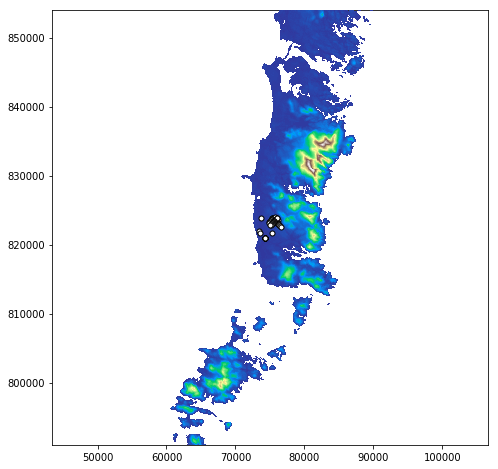

In [12]:
%matplotlib inline
import rasterio.plot
with rio.open('nasadem.asc.txt') as src:
    elev = src.read(1, masked=True)
    elev.mask = elev.mask | elev.data == 0
    extent = rio.plot.plotting_extent(src)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(elev, extent=extent, cmap='terrain', zorder=20)
ax.plot(locs_gdf.GridRefX, locs_gdf.GridRefY, zorder=50, ms=5, ls='none',  marker='o', mec='k', mfc='white')
ax.set(xlim=(BOX.left, BOX.right), ylim=(BOX.bottom, BOX.top), aspect='equal');

# Download corine

In [13]:
base_url = "https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2018_WM/MapServer/0/query?"
base_kws = {
    "geometry": ",".join(map(str, BOX)),
    "geometryType": "esriGeometryEnvelope",
    "inSR": 27700,
    "spatialRel": "esriSpatialRelIntersects",    
    "returnTrueCurves": True,
    "outSR":  27700,
    "returnZ": False,
    "returnM": False,
    "f": "json",
    "text":  "",
    "time":  "",
    "relationParam":  "",
    "outFields":  "",
    "maxAllowableOffset":  "",
    "geometryPrecision":  "",
    "orderByFields":  "",
    "groupByFieldsForStatistics":  "",
    "outStatistics":  "",
    "gdbVersion": "",
    "returnDistinctValues": False,
    "resultOffset":  "",
    "resultRecordCount":  "",
    "queryByDistance":  "",
    "returnExtentsOnly": False,
    "datumTransformation":  "",
    "parameterValues":  "",
    "rangeValues":  "",
}
import urllib3
url = base_url +  urllib3.request.urlencode({
    "returnIdsOnly": False,
    "returnCountOnly": True,
    "returnGeometry": False,
    **base_kws
})
n_expected = requests.get(url).json()["count"]
print(n_expected)
url = base_url +  urllib3.request.urlencode({
    "returnIdsOnly": True,
    "returnCountOnly": False,
    "returnGeometry": False,
    **base_kws
})
ids = requests.api.get(url).json()["objectIds"]
print(len(ids))
assert len(ids) == n_expected, "Number of ids doesn't match!!!"
MAX_RECORDS_COUNT = 1000
n, r = divmod(len(ids), MAX_RECORDS_COUNT)
n = n+1 if r > 0 else n
dl_list = []
for cpt in range(n):
    dl_list += [ids[cpt*MAX_RECORDS_COUNT:(cpt+1)*MAX_RECORDS_COUNT]]
print([len(x) for x in dl_list])

c_gdf = list()
for idList in dl_list:
    s = ",".join(map(str, idList))
    url = base_url +  urllib3.request.urlencode({
        #"where": f"OBJECTID in ({s})",
        "where": f"(OBJECTID >= {idList[0]}) AND (OBJECTID <= {idList[-1]})",
        #"objectIds": ",".join(map(str, idList)),
        "returnIdsOnly": False,
        "returnCountOnly": False,
        "returnGeometry": True,
        **base_kws
    })
    print(url)
    c_gdf += [gpd.read_file(url)]
len(c_gdf)
c_gdf = gpd.GeoDataFrame(pd.concat(c_gdf, axis=0).astype({"Code_18": "int"}), crs=locs_gdf.crs) 
c_gdf.Code_18.value_counts()

186
186
[186]
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2018_WM/MapServer/0/query?where=%28OBJECTID+%3E%3D+1626169%29+AND+%28OBJECTID+%3C%3D+2372333%29&returnIdsOnly=False&returnCountOnly=False&returnGeometry=True&geometry=43375.0%2C790975.0%2C106650.0%2C854025.0&geometryType=esriGeometryEnvelope&inSR=27700&spatialRel=esriSpatialRelIntersects&returnTrueCurves=True&outSR=27700&returnZ=False&returnM=False&f=json&text=&time=&relationParam=&outFields=&maxAllowableOffset=&geometryPrecision=&orderByFields=&groupByFieldsForStatistics=&outStatistics=&gdbVersion=&returnDistinctValues=False&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentsOnly=False&datumTransformation=&parameterValues=&rangeValues=


322    42
321    30
412    27
512    25
231    14
331    10
423    10
333     9
211     6
522     3
112     2
142     1
131     1
124     1
122     1
332     1
411     1
523     1
121     1
Name: Code_18, dtype: int64

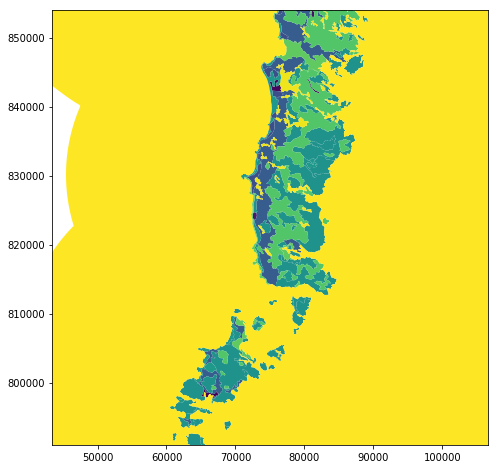

In [14]:
%matplotlib inline
import rasterio.plot
with rio.open('nasadem.tif') as src:
    elev = src.read(1, masked=True)
    elev.mask = elev.mask | elev.data == 0
    extent = rio.plot.plotting_extent(src)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
c_gdf.plot(ax=ax, column='Code_18')
ax.set(xlim=(BOX.left, BOX.right), ylim=(BOX.bottom, BOX.top), aspect='equal');

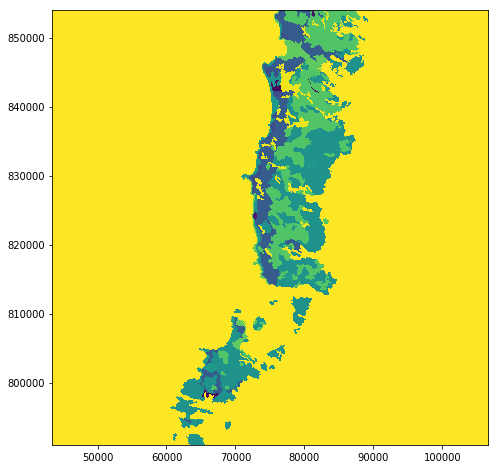

In [15]:
import rasterio.features
c_raster = rio.features.rasterize(
    c_gdf[["geometry", "Code_18"]].apply(tuple, axis=1),
    out_shape=elev.shape,
    transform=src.transform,
    fill=523,
    all_touched=True,
    dtype=rio.int16
)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(c_raster, extent=extent)
ax.set(xlim=(BOX.left, BOX.right), ylim=(BOX.bottom, BOX.top), aspect='equal');

In [17]:
fname = OUT_PATH / 'corine.landcover.asc.txt'
meta = src.meta.copy()
meta.update(driver='AAIGRID', dtype=rio.int16)
with rio.open(fname, "w", **meta) as out:
    out.write_band(1, c_raster)    
print(subprocess.check_output('gdalinfo corine.landcover.asc.txt', shell=True).decode('utf-8'))

Driver: AAIGrid/Arc/Info ASCII Grid
Files: corine.landcover.asc.txt
       corine.landcover.asc.prj
Size is 2531, 2522
Coordinate System is:
PROJCS["OSGB_1936_British_National_Grid",
    GEOGCS["GCS_OSGB 1936",
        DATUM["OSGB_1936",
            SPHEROID["Airy_1830",6377563.396,299.3249646]],
        PRIMEM["Greenwich",0],
        UNIT["Degree",0.017453292519943295]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",49],
    PARAMETER["central_meridian",-2],
    PARAMETER["scale_factor",0.9996012717],
    PARAMETER["false_easting",400000],
    PARAMETER["false_northing",-100000],
    UNIT["Meter",1]]
Origin = (43375.000000000000000,854025.000000000000000)
Pixel Size = (25.000000000000000,-25.000000000000000)
Corner Coordinates:
Upper Left  (   43375.000,  854025.000) (  7d56'43.18"W, 57d26'10.44"N)
Lower Left  (   43375.000,  790975.000) (  7d51'19.11"W, 56d52'22.04"N)
Upper Right (  106650.000,  854025.000) (  6d53'43.17"W, 57d28'53.40"N)
Lower Right (  10

In [18]:
sorted((_.name for _ in OUT_PATH.glob('*')))

['.env',
 '.ipynb_checkpoints',
 '00_download_elevation_lancover_locations.ipynb',
 '01_create_mesh.ipynb',
 '02_setup_simulation.ipynb',
 '03_post_processing.ipynb',
 '03_post_processing_.ipynb',
 '03_post_processing_v19.01.ipynb',
 'corine.landcover.asc',
 'corine.landcover.asc.prj',
 'corine.landcover.asc.txt',
 'corine.landcover.prj',
 'gramm_coupling.py',
 'locations',
 'locations.geojson',
 'maps',
 'meteo',
 'n56w006.hgt',
 'n56w007.hgt',
 'n56w008.hgt',
 'n57w006.hgt',
 'n57w007.hgt',
 'n57w008.hgt',
 'n58w006.hgt',
 'n58w007.hgt',
 'n58w008.hgt',
 'nasadem.asc.aux.xml',
 'nasadem.asc.txt',
 'nasadem.prj',
 'nasadem.tif',
 'nasadem.vrt']

In [19]:
%%bash
# Taken from https://github.com/dotnet/dotnet-docker/blob/master/src/sdk/3.1/bionic/amd64/Dockerfile
# Install .NET CLI dependencies
apt-get update
apt-get install -y --no-install-recommends \
    libc6 \
    libgcc1 \
    libgssapi-krb5-2 \
    libicu57 \
    libssl1.1 \
    libstdc++6 \
    zlib1g
rm -rf /var/lib/apt/lists/*

Ign:1 http://deb.debian.org/debian stretch InRelease
Get:2 http://security.debian.org/debian-security stretch/updates InRelease [53.0 kB]
Get:3 http://deb.debian.org/debian stretch-updates InRelease [93.6 kB]
Get:4 http://deb.debian.org/debian stretch Release [118 kB]
Get:5 http://deb.debian.org/debian stretch Release.gpg [2410 B]
Get:6 https://deb.nodesource.com/node_8.x stretch InRelease [4620 B]
Get:7 http://security.debian.org/debian-security stretch/updates/main amd64 Packages [635 kB]
Get:8 http://deb.debian.org/debian stretch-updates/main amd64 Packages [2596 B]
Ign:9 http://ftp.us.debian.org/debian stretch InRelease
Get:10 http://deb.debian.org/debian stretch/main amd64 Packages [7080 kB]
Get:11 http://ftp.us.debian.org/debian stretch Release [118 kB]
Get:12 https://deb.nodesource.com/node_8.x stretch/main Sources [762 B]
Get:13 http://ftp.us.debian.org/debian stretch Release.gpg [2410 B]
Get:14 https://deb.nodesource.com/node_8.x stretch/main amd64 Packages [1007 B]
Get:15 htt

In [20]:
"OK"

'OK'

In [21]:
%%bash
# Install .NET Core SDK
dotnet_sdk_version=3.1.404
curl -SL --output dotnet.tar.gz https://dotnetcli.azureedge.net/dotnet/Sdk/$dotnet_sdk_version/dotnet-sdk-$dotnet_sdk_version-linux-x64.tar.gz
dotnet_sha512='94d8eca3b4e2e6c36135794330ab196c621aee8392c2545a19a991222e804027f300d8efd152e9e4893c4c610d6be8eef195e30e6f6675285755df1ea49d3605'
echo "$dotnet_sha512 dotnet.tar.gz" | sha512sum -c - 
mkdir -p /usr/share/dotnet
tar -ozxf dotnet.tar.gz -C /usr/share/dotnet
rm dotnet.tar.gz
rm -f /usr/bin/dotnet
ln -s /usr/share/dotnet/dotnet /usr/bin/dotnet
# Trigger first run experience by running arbitrary cmd
dotnet --version

dotnet.tar.gz: OK
3.1.404


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  115M  100  115M    0     0  12.6M      0  0:00:09  0:00:09 --:--:-- 13.1M


In [22]:
GRAMM_PATH = Path('.').resolve().parent.parent.parent / 'GRAMM' / 'src' / 'bin'
GRAMM_EXEC = next(GRAMM_PATH.glob('**/Release/**/linux-x64/publish/GRAMM'))
print(str(GRAMM_EXEC))

StopIteration: 